<a target="_blank" href="https://colab.research.google.com/github/sakarimov/Basic-ML-Model/blob/main/JanKenPon%20CNN%20Image%20Recognizer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Student Name** : Sulthan A. Karimov
# **Username** : sulthankarimov
# **Email** : sulthankarimov@gmail.com

In [1]:
!pip install split-folders[full] matplotlib jupyter_http_over_ws

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [4]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

IN_COLAB

False

In [5]:
# sometime i run this notebook on my laptop for testing purpose
local_dir = (
    'datasets/images/' if IN_COLAB == False
    else '/tmp/'
)

dataset_name = 'rockpaperscissors'
local_data = local_dir + dataset_name
local_zip = local_data + '.zip'
print(local_zip)

datasets/images/rockpaperscissors.zip


In [6]:
!test -f $local_zip || wget --no-check-certificate \
 https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
 -o $local_zip

In [7]:
import zipfile, os, shutil, splitfolders, re

In [8]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(local_dir)
zip_ref.close()

In [9]:
#shutil.rmtree(local_data + '/rps-cv-images')
#os.remove(local_data + '/README_rpc-cv-images.txt')
print(os.listdir(local_data))

base_dir = local_dir + '/rps'
#if os.path.exists(base_dir) == True:
#  shutil.rmtree(base_dir)
#
#splitfolders.ratio(local_data, base_dir, ratio=(.6,.4))
train_dir = os.path.join(base_dir, 'train')
#print()
#print('amount of training sample : ', sum(len(files) for _, _, files in os.walk(re.escape(base_dir) + r'/train')))
validation_dir = os.path.join(base_dir, 'val')
#print('amount of validation sample : ', sum(len(files) for _, _, files in os.walk(re.escape(base_dir) + r'/val')))
test_dir = os.path.join(base_dir, 'test')

['paper', 'rock', 'scissors', 'rps-cv-images', 'README_rpc-cv-images.txt']


In [10]:
os.listdir(train_dir)

['paper', 'rock', 'scissors']

In [11]:
os.listdir(validation_dir)

['paper', 'rock', 'scissors']

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    preprocessing_function = preprocess_input,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

In [16]:
import numpy as np

mean = np.array([123.68, 116.779, 103.939], dtype = 'float32')
train_datagen.mean = mean
test_datagen.mean = mean

In [19]:
from imutils import paths

BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

totalTrain = len(list(paths.list_images(train_dir)))
totalVal = len(list(paths.list_images(validation_dir)))
totalTest = len(list(paths.list_images(test_dir)))

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [22]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [23]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [24]:
for layer in baseModel.layers:
    layer.trainable = False

In [25]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=train_generator,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=validation_generator,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=50)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718224121.040743     391 service.cc:145] XLA service 0x7d0df0004ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718224121.040781     391 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2024-06-12 20:28:45.772338: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-12 20:28:

41/41 ━━━━━━━━━━━━━━━━━━━━ 63s 761ms/step - accuracy: 0.3100 - loss: 1.7448 - val_accuracy: 0.5579 - val_loss: 1.0187
Epoch 2/50


2024-06-12 20:29:39.635149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:29:39.635210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.7863
Epoch 3/50


2024-06-12 20:29:52.758853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:29:52.758900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 744ms/step - accuracy: 0.5413 - loss: 0.9670 - val_accuracy: 0.8773 - val_loss: 0.7063
Epoch 4/50


2024-06-12 20:30:26.072735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:30:26.072783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5060
Epoch 5/50


2024-06-12 20:30:26.298502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:30:26.298567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 748ms/step - accuracy: 0.6093 - loss: 0.8758 - val_accuracy: 0.8981 - val_loss: 0.6533
Epoch 6/50


2024-06-12 20:30:59.754450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:30:59.754496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5584
Epoch 7/50


2024-06-12 20:30:59.978524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:30:59.978573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 757ms/step - accuracy: 0.5797 - loss: 0.8718 - val_accuracy: 0.4560 - val_loss: 0.8672
Epoch 8/50


2024-06-12 20:31:33.860066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:31:33.860104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0833 - val_loss: 1.2654
Epoch 9/50


2024-06-12 20:31:34.089792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:31:34.089868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 770ms/step - accuracy: 0.6020 - loss: 0.7566 - val_accuracy: 0.3333 - val_loss: 1.5809
Epoch 10/50


2024-06-12 20:32:08.581439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:32:08.581475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1187
Epoch 11/50


2024-06-12 20:32:08.814128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:32:08.814173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 791ms/step - accuracy: 0.4770 - loss: 1.2934 - val_accuracy: 0.6007 - val_loss: 0.7585
Epoch 12/50


2024-06-12 20:32:43.800931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:32:43.800975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.7931
Epoch 13/50


2024-06-12 20:32:44.036491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:32:44.036542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 824ms/step - accuracy: 0.6956 - loss: 0.7304 - val_accuracy: 0.6157 - val_loss: 0.7265
Epoch 14/50


2024-06-12 20:33:20.324024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:33:20.324079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3832
Epoch 15/50


2024-06-12 20:33:20.561322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:33:20.561373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 796ms/step - accuracy: 0.7370 - loss: 0.6708 - val_accuracy: 0.9248 - val_loss: 0.5444
Epoch 16/50


2024-06-12 20:33:58.945787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:33:58.945840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3982
Epoch 17/50


2024-06-12 20:33:59.185101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:33:59.185137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 835ms/step - accuracy: 0.7970 - loss: 0.6536 - val_accuracy: 0.8542 - val_loss: 0.5225
Epoch 18/50


2024-06-12 20:34:35.995713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:34:35.995757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2154
Epoch 19/50


2024-06-12 20:34:36.235244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:34:36.235281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 843ms/step - accuracy: 0.8374 - loss: 0.5926 - val_accuracy: 0.8171 - val_loss: 0.5402
Epoch 20/50


2024-06-12 20:35:14.218389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:35:14.218506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1443
Epoch 21/50


2024-06-12 20:35:14.468929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:35:14.469046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 858ms/step - accuracy: 0.8305 - loss: 0.5133 - val_accuracy: 0.7836 - val_loss: 0.5487
Epoch 22/50


2024-06-12 20:35:53.110667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:35:53.110711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.7082
Epoch 23/50


2024-06-12 20:35:53.354474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:35:53.354507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 865ms/step - accuracy: 0.8415 - loss: 0.5190 - val_accuracy: 0.9491 - val_loss: 0.3825
Epoch 24/50


2024-06-12 20:36:32.654098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:36:32.654145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.5079
Epoch 25/50


2024-06-12 20:36:32.898088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:36:32.898126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 859ms/step - accuracy: 0.9038 - loss: 0.4358 - val_accuracy: 0.8160 - val_loss: 0.4932
Epoch 26/50


2024-06-12 20:37:10.677937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:37:10.678005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4167 - val_loss: 0.9909
Epoch 27/50


2024-06-12 20:37:10.921326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:37:10.921358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 861ms/step - accuracy: 0.9126 - loss: 0.3843 - val_accuracy: 0.8912 - val_loss: 0.3543
Epoch 28/50


2024-06-12 20:37:48.730701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:37:48.730819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1614
Epoch 29/50


2024-06-12 20:37:48.987692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:37:48.987809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 872ms/step - accuracy: 0.8758 - loss: 0.4294 - val_accuracy: 0.8843 - val_loss: 0.3422
Epoch 30/50


2024-06-12 20:38:28.343615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:38:28.343652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2412
Epoch 31/50


2024-06-12 20:38:28.587481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:38:28.587594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 882ms/step - accuracy: 0.8910 - loss: 0.3800 - val_accuracy: 0.9178 - val_loss: 0.2997
Epoch 32/50


2024-06-12 20:39:08.017964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:39:08.018001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2475
Epoch 33/50


2024-06-12 20:39:08.262033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:39:08.262073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 882ms/step - accuracy: 0.9415 - loss: 0.3100 - val_accuracy: 0.9271 - val_loss: 0.2968
Epoch 34/50


2024-06-12 20:39:47.616358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:39:47.616392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0944
Epoch 35/50


2024-06-12 20:39:47.860533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:39:47.860569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 878ms/step - accuracy: 0.9135 - loss: 0.3207 - val_accuracy: 0.9606 - val_loss: 0.2419
Epoch 36/50


2024-06-12 20:40:27.095507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:40:27.095555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2618
Epoch 37/50


2024-06-12 20:40:27.344223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:40:27.344262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 875ms/step - accuracy: 0.9342 - loss: 0.3000 - val_accuracy: 0.9525 - val_loss: 0.2248
Epoch 38/50


2024-06-12 20:41:06.457417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:41:06.457465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1661
Epoch 39/50


2024-06-12 20:41:06.705832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:41:06.705873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 886ms/step - accuracy: 0.9388 - loss: 0.2955 - val_accuracy: 0.9618 - val_loss: 0.2160
Epoch 40/50


2024-06-12 20:41:45.470437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:41:45.470474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1889
Epoch 41/50


2024-06-12 20:41:45.721050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:41:45.721088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 887ms/step - accuracy: 0.9448 - loss: 0.2558 - val_accuracy: 0.9306 - val_loss: 0.2388
Epoch 42/50


2024-06-12 20:42:25.255681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:42:25.255724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0899
Epoch 43/50


2024-06-12 20:42:25.504221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:42:25.504257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 901ms/step - accuracy: 0.9169 - loss: 0.2853 - val_accuracy: 0.9375 - val_loss: 0.2164
Epoch 44/50


2024-06-12 20:43:05.648325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-12 20:43:05.648366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1274
Epoch 45/50


2024-06-12 20:43:05.898843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:43:05.898882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 883ms/step - accuracy: 0.9541 - loss: 0.2370 - val_accuracy: 0.9583 - val_loss: 0.2246
Epoch 46/50


2024-06-12 20:43:44.626932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:43:44.626976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.3960
Epoch 47/50


2024-06-12 20:43:44.877318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:43:44.877357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - accuracy: 0.9367 - loss: 0.2383 - val_accuracy: 0.9606 - val_loss: 0.1791
Epoch 48/50


2024-06-12 20:44:24.723529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:44:24.723580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1383
Epoch 49/50


2024-06-12 20:44:24.978541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:44:24.978599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 895ms/step - accuracy: 0.9565 - loss: 0.2101 - val_accuracy: 0.9525 - val_loss: 0.1927
Epoch 50/50


2024-06-12 20:45:06.474199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:45:06.474237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0795
[INFO] evaluating after fine-tuning network head...


2024-06-12 20:45:06.723387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:45:06.723429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


NameError: name 'testGen' is not defined

In [27]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict(x=test_generator,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))
#plot_training(H, 50, WARMUP_PLOT_PATH)

[INFO] evaluating after fine-tuning network head...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
              precision    recall  f1-score   support

       paper       1.00      0.75      0.86         4
        rock       1.00      1.00      1.00         4
    scissors       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



In [28]:
# reset our data generators
train_generator.reset()
validation_generator.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<InputLayer name=input_layer, built=True>: False
<Conv2D name=block1_conv1, built=True>: False
<Conv2D name=block1_conv2, built=True>: False
<MaxPooling2D name=block1_pool, built=True>: False
<Conv2D name=block2_conv1, built=True>: False
<Conv2D name=block2_conv2, built=True>: False
<MaxPooling2D name=block2_pool, built=True>: False
<Conv2D name=block3_conv1, built=True>: False
<Conv2D name=block3_conv2, built=True>: False
<Conv2D name=block3_conv3, built=True>: False
<MaxPooling2D name=block3_pool, built=True>: False
<Conv2D name=block4_conv1, built=True>: False
<Conv2D name=block4_conv2, built=True>: False
<Conv2D name=block4_conv3, built=True>: False
<MaxPooling2D name=block4_pool, built=True>: False
<Conv2D name=block5_conv1, built=True>: True
<Conv2D name=block5_conv2, built=True>: True
<Conv2D name=block5_conv3, built=True>: True
<MaxPooling2D name=block5_pool, built=True>: True


In [31]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(
	x=train_generator,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=validation_generator,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=20)

[INFO] re-compiling model...
Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 836ms/step - accuracy: 0.9556 - loss: 0.2143 - val_accuracy: 0.9803 - val_loss: 0.1293
Epoch 2/20


2024-06-12 20:48:51.316747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-12 20:48:51.316819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1540
Epoch 3/20


2024-06-12 20:48:51.839285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:48:51.839336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 859ms/step - accuracy: 0.9725 - loss: 0.1410 - val_accuracy: 0.9757 - val_loss: 0.1114
Epoch 4/20


2024-06-12 20:49:29.669565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:49:29.669609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1684
Epoch 5/20


2024-06-12 20:49:29.905898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:49:29.905999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 905ms/step - accuracy: 0.9641 - loss: 0.1270 - val_accuracy: 0.9826 - val_loss: 0.0842
Epoch 6/20


2024-06-12 20:50:10.190890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:50:10.190932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0761
Epoch 7/20


2024-06-12 20:50:10.429574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:50:10.429621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 924ms/step - accuracy: 0.9756 - loss: 0.1004 - val_accuracy: 0.9815 - val_loss: 0.0757
Epoch 8/20


2024-06-12 20:50:51.569574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:50:51.569610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0685
Epoch 9/20


2024-06-12 20:50:51.814021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:50:51.814133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 926ms/step - accuracy: 0.9818 - loss: 0.0780 - val_accuracy: 0.9861 - val_loss: 0.0669
Epoch 10/20


2024-06-12 20:51:32.903575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:51:32.903641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0997
Epoch 11/20


2024-06-12 20:51:33.147017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:51:33.147065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 940ms/step - accuracy: 0.9889 - loss: 0.0592 - val_accuracy: 0.9884 - val_loss: 0.0616
Epoch 12/20


2024-06-12 20:52:14.912508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:52:14.912545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1084
Epoch 13/20


2024-06-12 20:52:15.155334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:52:15.155375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 953ms/step - accuracy: 0.9860 - loss: 0.0519 - val_accuracy: 0.9907 - val_loss: 0.0509
Epoch 14/20


2024-06-12 20:52:57.429124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:52:57.429241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0613
Epoch 15/20


2024-06-12 20:52:57.684282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:52:57.684326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 954ms/step - accuracy: 0.9909 - loss: 0.0402 - val_accuracy: 0.9896 - val_loss: 0.0545
Epoch 16/20


2024-06-12 20:53:39.247139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:53:39.247185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1114
Epoch 17/20


2024-06-12 20:53:39.496376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:53:39.496416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 956ms/step - accuracy: 0.9901 - loss: 0.0454 - val_accuracy: 0.9861 - val_loss: 0.0469
Epoch 18/20


2024-06-12 20:54:21.276406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:54:21.276502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0226
Epoch 19/20


2024-06-12 20:54:21.538990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:54:21.539103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 959ms/step - accuracy: 0.9878 - loss: 0.0402 - val_accuracy: 0.9919 - val_loss: 0.0421
Epoch 20/20


2024-06-12 20:55:03.287270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:55:03.287313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0473


2024-06-12 20:55:03.537805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 20:55:03.537857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


In [32]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
test_generator.reset()
predIdxs = model.predict(x=test_generator,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))
#plot_training(H, 20, config.UNFROZEN_PLOT_PATH)
# serialize the model to disk
#print("[INFO] serializing network...")
#model.save(config.MODEL_PATH, save_format="h5")

[INFO] evaluating after fine-tuning network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00         4
        rock       1.00      1.00      1.00         4
    scissors       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


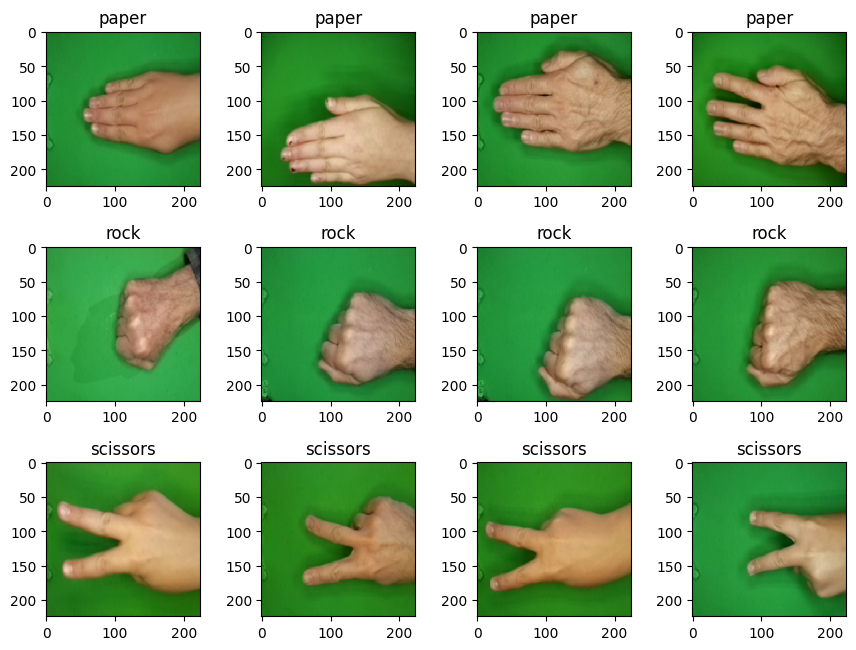

In [47]:
import os
import numpy as np
#from google.colab import files
from tensorflow.keras.preprocessing import image
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

testdir = 'datasets/images/rps/test/'
uploaded = list(paths.list_images(testdir))
fig = plt.figure(figsize= (10, 10))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(len(uploaded)):
    path = uploaded[i]
    img = image.load_img(path, target_size = (224,224))

    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(img)
    images = image.img_to_array(img)
    images = np.expand_dims(images, axis=0)
    images = preprocess_input(images)
    #images = np.vstack([x])
    pred = model.predict(images)
    ax.title.set_text(list(train_generator.class_indices.keys())[np.argmax(pred, axis = 1)[0]])
